# Several code snippets for the pizza project

The data can be downloaded from the page: http://pizzagan.csail.mit.edu/

There are two types of data: synthetic and real. Use the dataset you want, but beware that they do not have the same labels. They were not originally used for label prediction.



## Path setup for data and networks

In [2]:
# from google.colab import drive

# drive.mount('/content/gdrive/')

DATA_DIR =  './pizzaGANsyntheticdata'


## Useful libraries

In [20]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

import seaborn as sns
sns.set_style('darkgrid')

#import shutil

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# scikitlearn
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Pytorch
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.optim as optim
# from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.nn as nn


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using", "cuda:0" if torch.cuda.is_available() else "cpu")
# verify that the installed cuda version is anterior (or equal) to the cuda version of !nvidia-smi 
# print(torch.version.cuda)

if (torch.cuda.is_available()):
  !nvidia-smi

using cpu


# 0 - Useful functions


In this section, we define all the functions that we will use afterward. First there are the functions used to manage the data, then the functions to train and evaluate the network.

## Data management

### Download dataset and unzip the archive
Uncomment the following lines to do it.

In [4]:
#!cd /content/gdrive/MyDrive/Colab\ Notebooks/Projet\ MI201/

#!ls

#!wget http://pizzagan.csail.mit.edu/pizzaGANsyntheticdata.zip

# !unzip '/content/gdrive/MyDrive/Colab Notebooks/Projet MI201/pizzaGANsyntheticdata' -d '/content/gdrive/MyDrive/Colab Notebooks/Projet MI201'

### Read data

This function allows to build a train, validation and test dataset. It can either use a specific test set and split the train set in the actual train set and the validation set or create a train, validation and test set.

In [5]:
def load_image_list(train_label_path, test_label_path=None, max_image=None, test_size=0.3, val_size=0.2): 
    # get images
    y_all = np.loadtxt(os.path.join(DATA_DIR, train_label_path))
    if max_image is not None: # limit the number of image to max_image
        y_all = y_all[:min(len(y_all), max_image)]
    x_all = np.arange(y_all.shape[0])

    # Create train, val and test splits
    
    if test_label_path is not None: # differentiate when there is a test dataset and when there is just all the data
        x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=val_size, random_state=123)

        y_test = np.loadtxt(os.path.join(DATA_DIR, test_label_path))
        x_test = np.arange(y_test.shape[0])
    else:
        x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=test_size, random_state=123)
        
        x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=val_size/(1-test_size), random_state=123)
        
    print(y_train.shape)
    print(y_val.shape)
    print(y_test.shape)
    
    return x_train, y_train, x_val, y_val, x_test, y_test


### Store train images in memory

This should make learning faster.

In [6]:
def store_image(image_idx, train_data_path, filename, image_format="{:04d}.png", image_size=224):
    # Test if the numpy file exists
    if (os.path.exists(os.path.join(DATA_DIR, train_data_path, filename))):
      img_data_tensor = np.load(os.path.join(DATA_DIR, train_data_path, filename))
      img_all = img_data_tensor['img_data']
    else:
      img_all = []

      for idx in tqdm(image_idx):
          img_name = image_format.format(idx+1)
          x = Image.open(os.path.join(DATA_DIR, train_data_path, 'images', img_name))
          img_all.append(np.array(x.resize((image_size, image_size))))

      np.savez_compressed(os.path.join(DATA_DIR, train_data_path, filename), img_data=np.array(img_all))
    
    return img_all

### Dataset class

In [7]:
class myDataset(Dataset):
    """Pizza dataset"""
    
    def __init__(self, x_idx, y, img_path='/content/gdrive/MyDrive/Colab Notebooks/syntheticDataset/train/images', img_data = None, transform=None):
      """
      Args:
      """
      self.x_idx = x_idx
      self.y = y
      self.img_path = img_path
      self.transform = transform
      self.img_data = img_data     
    
    def __getitem__(self, idx):
      if isinstance(self.img_data,np.ndarray):
        x = Image.fromarray(self.img_data[idx,:,:,:])
      else:
        img_name = "{:04d}.png".format(idx+1)
        x = Image.open(os.path.join(self.img_path, img_name))
      y = self.y[idx,:]
      if self.transform:
          x = self.transform(x)
      y = np.int64(y)
      return x, y
            
    def __len__(self):
        return int(len(self.x_idx))


### Data loaders

In order to make the code cleaner, we made a function to create the dataset. It is not general and only usable for our case but it also helps to understand how datasets are computed.

In [8]:
def create_dataloader(x_data, y_data, img_data, data_path, datasetClass, batch_size, transform=None, shuffle=False):
    kwargs = {'num_workers': 2, 'pin_memory': True} if torch.cuda.is_available() else {}
    
    img_data = img_data[x_data,:,:,:]
    raw_dataset = datasetClass(x_train, y_train, img_path=data_path, img_data=img_data, transform = transform)
    dataloader = DataLoader(raw_dataset, batch_size=batch_size, shuffle=shuffle, **kwargs)
    
    return dataloader

## Network training

In [31]:
from IPython.display import clear_output

import copy
import random

def train_model_multilabel(model, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=5):
  # list for saving accuracies
  train_perf = []
  test_perf = []
  train_losses = []

  # training of the model
  for epoch in range(num_epochs):
      print(epoch,"/",num_epochs)
      model.train()
      for inputs, targets in trainloader:     ## on itere sur les données 
          # inputs is 25 RGB images
          # outputs is 25 targets
          inputs, targets = inputs.cuda(),targets.cuda()

          predictions = model(inputs)    ## on les fait rentrer dans le réseau
          targets = targets.to(torch.float) # FloatTensor needed

          loss = criterion(predictions,targets)    ## on compare la sortie courante à la sortie voulue
          optimizer.zero_grad() ## supprime les gradients courants
          loss.backward() ## le gradient -- la magie par rapport à comment c'était long en cours :-)
          optimizer.step() ## on actualise les poids pour que la sortie courante soit plus proche que la sortie voulue
          train_losses.append(loss)
          train_perf.append(accuracy_score(targets.cpu().numpy(), (predictions.cpu().detach().numpy() > 0.5)))
          if random.randint(0,90)==0:
              print("\tloss=",loss) ## on affiche pour valider que ça diverge pas

  # test of the model
  model.eval()
  with torch.no_grad():  ### no need to calculate the gradients
      for inputs, targets in valloader:
          inputs = inputs.cuda()
          outputs = model(inputs)
          test_perf.append(accuracy_score(targets.cpu().numpy(), (outputs.cpu().numpy() > 0.5)))

  # beep noise when training finished
  !echo -e '\a'
        
# Learning step
  return model, train_perf, test_perf, train_losses


## Network evaluation


An example of performance computation.

The problem being a multi-label prediction, performance metrics are different compared to the ones we used in class. The following ones appeared to be the most frequently used and relevant.



*   Precision : TP/(TP+FP) --> Ability to predict the positive class. Closer to 1 = better
*   Recall : TP/(TP+FN) --> Ability to detect positives. Closer to 1 = better
*   F1-score : 2.precision.recall/(precision+recall)
*   Support : Number of occurences of the label in the true labels


However, the multilabel confusion matrix did not seem useful to us as it uses a one-vs-rest representation for each class.

In [14]:
def model_evaluation(network, nb_labels, dataloader, labels=None, display=0):

  # set the model to evaluation mode
  network.eval()

  # create the vectors necessary for the KPI
  perf_label_test = np.zeros((1,nb_labels))
  all_eval_pred = np.zeros(shape=(0,nb_labels))
  all_eval_targets = np.zeros((0,nb_labels))


  # tell not to reserve memory space for gradients (much faster)
  with torch.no_grad():
      for inputs, targets in tqdm(dataloader, ncols=80):

          inputs = inputs.to(device)
          targets = targets.to(device)

          # Compute outputs
          outputs = network(inputs)
          outputs_np = outputs.cpu().detach().numpy()
          targets_np = targets.cpu().detach().numpy()

          # Compute the predictions
          pred = (outputs_np > 0)

          # Concatenate pred and targets to calculate the classification report
          all_eval_pred = np.concatenate((all_eval_pred, pred))
          all_eval_targets = np.concatenate((all_eval_targets, targets_np))
          # update the performance
          perf_label_test = perf_label_test + (targets_np == pred).sum(axis=0)

          # https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics
          # https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report


  # Calculate KPI
  perf_label_test = perf_label_test / len(dataloader.dataset)
  metrics_report = classification_report(all_eval_targets, all_eval_pred, target_names=labels)

  # Prints the classification report and the performance (per label)
  if display==1:
    print("\nPerformance per label :",perf_label_test)
    print("Mean of performance :",sum(perf_label_test[0])/len(perf_label_test[0]))
    print(metrics_report)

  return perf_label_test, metrics_report


### Display what the network guessed

In [32]:
def show_result_on_random_batch(network, labels_name, test_dataloader):
    def label_in_image(vector):
        lbl = []

        for i in range(len(vector)):
            if vector[i]:
                lbl.append(labels_name[i])
        return lbl


    with torch.no_grad():
        r = random.randint(0, len(iter(test_dataloader)))
        print(f"Batch n°{r}")
        for i in range(r):
            inputs, targets = next(iter(test_dataloader))

        inputs_cuda = inputs.to(device)

        # compute outputs
        outputs = network(inputs_cuda)
        outputs_np = outputs.cpu().detach().numpy()

        for idx in range(batch_size):
            out = torchvision.utils.make_grid(inputs[idx, :, :, :])
            plt.imshow(out.permute(1, 2, 0))
            plt.show()


            print("IA finds", ', '.join(label_in_image(outputs_np[idx, :] > 0)))
            print("Correct answer is", ', '.join(label_in_image(targets[idx, :] == 1)))

# I - Finding topping of synthetic pizzas

## Loading dataset

In [26]:
x_train, y_train, x_val, y_val, x_test, y_test = load_image_list('syntheticDataset/train/trainLabels.txt',
                                                                'syntheticDataset/test/testLabels.txt',
                                                                 val_size=0.1)

img_all = store_image(np.concatenate((x_train, x_val)), 'syntheticDataset/train', 'img_data_224.npz')

nlabel = y_train.shape[1]
topping_labels = ["pepperoni", "mushrooms", "peppers", "olives", "basil", "bacon", "broccoli", "pineapple", "tomatoes", "onions"]

(4473, 10)
(498, 10)
(497, 10)


## Visualising the dataset

### Display one sample image

0046.png


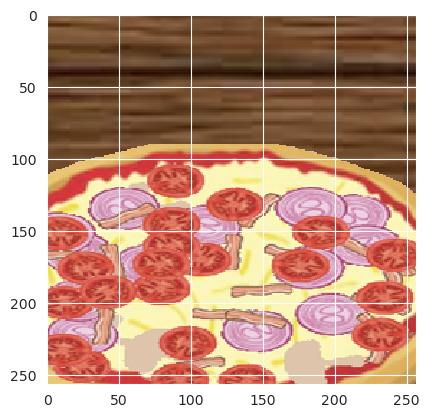

In [10]:
idx = 45

img_name = "{:04d}.png".format(idx+1)
print(img_name)
img_path = os.path.join(DATA_DIR, 'syntheticDataset/train/images')

img = Image.open(os.path.join(img_path, img_name))
plt.imshow(img)
plt.show()

## A - First approch with a CNN

We decided to start with a simple CNN. There are 3 convolutions followed by 2 extra layers.

### Simple network definition

An elementary convolutional network with input datasize of 32x32.

In [25]:
# network class
class SimpleCNN(nn.Module):
# Network requires 32x32 input images  
  def __init__(self, nlabel = 10):
    super(SimpleCNN, self).__init__()
    self.nlabel = nlabel
    
    # define here the convolutions and linear layers
    self.conv1 = nn.Conv2d(3,16,3)
    self.conv2 = nn.Conv2d(16,32,3)
    self.conv3 = nn.Conv2d(32,64,3)
    self.lin1 = nn.Linear(256, 128)
    self.lin2 = nn.Linear(128, self.nlabel)
    
  def forward(self, x):
    
    # 32x32
    
    # define here the forward pass
    x1 = self.conv1(x)
    x1r = F.relu(x1)
    x1p = F.max_pool2d(x1r, 2)
    
    # 16x16
    x2 = self.conv2(x1p)
    x2r = F.relu(x2)
    x2p = F.max_pool2d(x2r, 2)
    
    # 8x8
    x3 = self.conv3(x2p)
    x3r = F.relu(x3)
    x3p = F.max_pool2d(x3r, 2)
    
    # 4x4
    y0 = x3p.view(x3p.size(0), -1)
    y1 = self.lin1(y0)
    y1r = F.relu(y1)
    y2 = self.lin2(y1r)
    
    return y2
    
tag = "simpleCNN"
if os.path.exists("networks/network_" + tag + ".pth"):
    print("Loading pretrained network")
    network = torch.load("networks/network_" + tag + ".pth")
else:
    network = SimpleCNN()

Loading pretrained network


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

### Create dataloaders

First we need to create the dataloader using the previously defined function.
In order to match the input size of simpleCNN, we had to modify the input_size and set it to 32.

In [11]:
batch_size = 25

# 224 for efficientNet, 32 for simple CNN
# input_size = 224
input_size = 32

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create the list of transformations that will be computed on the training pictures to make the model more robust
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                         transforms.RandomVerticalFlip(),
                                         transforms.ColorJitter(brightness=32. / 255., saturation=0.5),
                                         transforms.Resize(input_size),
                                         transforms.ToTensor(),
                                     normalize])

# Create the list of transformations necessary for the data to fit the model
val_transform = transforms.Compose([transforms.Resize(input_size),
                                    transforms.ToTensor(),
                                   normalize])
        
# Conversion of img_all to a ndarray
img_data=np.array(img_all) # an error occured and we noticed that img_data=np.array(img_all) appeared in np.savez_compressed. hence our idea to add that line


# Creation of the dataloader for the model training
train_data_path=img_path = os.path.join(DATA_DIR, 'syntheticDataset/train/images')
train_dataloader = create_dataloader(x_train, y_train, img_data, train_data_path, myDataset, batch_size, transform=train_transform, shuffle=True)


# Creation of the dataloader for the model test
test_data_path=img_path = os.path.join(DATA_DIR, 'syntheticDataset/test/images')
test_dataloader = create_dataloader(x_test, y_test, img_data, test_data_path, myDataset, batch_size, transform=val_transform, shuffle=False)


# Creation of the dataloader for the model validation
val_dataloader = create_dataloader(x_val, y_val, img_data, train_data_path, myDataset, batch_size, transform=val_transform, shuffle=False)

### Displaying the training dataloader
Before continuing, let's check what the dataloader will actually send to the CNN. It also allows to validate the dataloaders.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([25, 3, 32, 32])


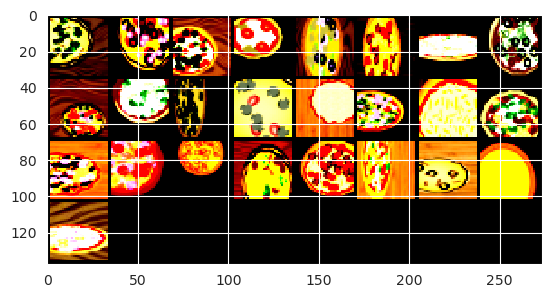

In [13]:
# Show batch of images
#it = iter(train_dataloader)
sample,labels = next(iter(train_dataloader))
print(sample.shape)

out = torchvision.utils.make_grid(sample)
plt.imshow(out.permute(1, 2, 0))

### The training procedure

In [24]:
# Transfer network to GPU
network.to(device)

# Define learning components (to be used in the training function)
optimizer = optim.Adam(network.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()
scheduler = None

# Training 
max_epoch = 2 # initial 20
trained_model, train_error, test_error, train_losses = train_model_multilabel(network, nlabel, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs=max_epoch)

if input("Do you want to save ? (Y/n)") == "Y":
    torch.save(trained_model, os.path.join('networks/network_{:s}.pth'.format(tag)))

network = trained_model

print("Train accuracies")
print(train_error)
print("Test accuracies")
print(test_error)
print("Train losses")
print(train_losses)

NameError: name 'network' is not defined

### Evaluate the performances of the network

This part computes KPI and displays the predictions of the network. The visual part allowed us to make the project more tangible and fun.

In [27]:
perf_label_test, metrics_report = model_evaluation(network = network, dataloader=test_dataloader, labels=topping_labels, nb_labels=nlabel, display=1)

# show what the network guessed on a random batch
show_result_on_random_batch(network, topping_labels, test_dataloader)

NameError: name 'network' is not defined

## Our results concerning simpleCNN on the synthetic dataset

**TODO** discuss the best result and add graphs (using json on the git and a function todo)


## B - A second approach using efficientNet

Now, we'll use efficientNet with the default weights and retrain the model with the dataset.

Because the image resolution needs to be 224x224 (versus 32x32 previously), the dataloaders need to be recreated.

In [29]:
batch_size = 25
input_size = 224

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create the list of transformations that will be computed on the training pictures to make the model more robust
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                         transforms.RandomVerticalFlip(),
                                         transforms.ColorJitter(brightness=32. / 255., saturation=0.5),
                                         transforms.Resize(input_size),
                                         transforms.ToTensor(),
                                     normalize])

# Create the list of transformations necessary for the data to fit the model
val_transform = transforms.Compose([transforms.Resize(input_size),
                                    transforms.ToTensor(),
                                   normalize])
        
# Conversion of img_all to a ndarray
img_data=np.array(img_all) # an error occured and we noticed that img_data=np.array(img_all) appeared in np.savez_compressed. hence our idea to add that line


# Creation of the dataloader for the model training
train_data_path=img_path = os.path.join(DATA_DIR, 'syntheticDataset/train/images')
train_dataloader = create_dataloader(x_train, y_train, img_data, train_data_path, myDataset, batch_size, transform=train_transform, shuffle=True)


# Creation of the dataloader for the model test
test_data_path=img_path = os.path.join(DATA_DIR, 'syntheticDataset/test/images')
test_dataloader = create_dataloader(x_test, y_test, img_data, test_data_path, myDataset, batch_size, transform=val_transform, shuffle=False)


# Creation of the dataloader for the model validation
val_dataloader = create_dataloader(x_val, y_val, img_data, train_data_path, myDataset, batch_size, transform=val_transform, shuffle=False)

Then we load a pre-trained effecientNet network from torchvision

In [30]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

tag = "efficientNet"

network = torchvision.models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
num_ftrs = network.classifier[1].in_features
network.classifier[1]= nn.Linear(num_ftrs, nlabel) # layer to match to the number of labels

if os.path.exists("networks/network_synthetic_" + tag + ".pth"):
    print("Loading pretrained network")
    network = torch.load("networks/network_synthetic_" + tag + ".pth")

### The training procedure

Despite the network being pre-trained, the weights have to be adjusted to our project in order to get decent performances.

In [ ]:
# Transfer network to GPU
network.to(device)

# Define learning components (to be used in the learning function)
optimizer = optim.Adam(network.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()
scheduler = None

# Learning 
max_epoch = 2 # initial 20
learned_model, train_error, test_error, train_losses = train_model_multilabel(network, nlabel, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs=max_epoch)

if input("Do you want to save ? (Y/n)") == "Y":
    torch.save(learned_model, os.path.join('networks/network_synthetic_{:s}.pth'.format(tag)))

network = learned_model

print("Train accuracies")
print(train_error)
print("Test accuracies")
print(test_error)
print("Train losses")
print(train_losses)

### Evaluate the performances of the network

In [33]:
perf_label_test, metrics_report = model_evaluation(network = network, dataloader=test_dataloader, labels=topping_labels, nb_labels=nlabel, display=1)

# show what the network guessed on a random batch
show_result_on_random_batch(network, topping_labels, test_dataloader)

 11%|████▍                                     | 19/179 [00:05<00:50,  3.19it/s]


IndexError: index 497 is out of bounds for axis 0 with size 497

## Our results concerning efficientNET on the synthetic dataset

**TODO** discuss the best result and add graphs (using json on the git and a function todo)


# 2 - Finding topping of real pizzas

In [ ]:
# TODO

**TODO** Remove ?

## Learning

There are several possibilities to solve the problem:

* Extract good features and apply a simple predictor. The problem is to find good features for the problem: you know what they can be and how to compute them, or you can rely on "generic" features like bag of visual words, histograms or deep features.

* Work on raw data and build the label predictor directly. This is typically an approach for deep learning.

Notice that the problem is **multi-label prediction**, not classification. Each image may be characterized by several labels.
